In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# jedi 0.14.1 tab completion fails; will supposedly be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False

In [1]:
import ref_pixels
from ref_pixels import robust, reffix_hxrg

from astropy.io import fits

In [4]:
# Random function for plotting image cutouts
def plot_subsections(im, title=None):
    fig, axes = plt.subplots(1,3, figsize=(12,4.5), sharey=True)

    titles = ['Amp1 Cutout', 'Amp1/Amp2 Cutout', 'Amp4 Cutout']
    x1_arr = [0,512-51,nx-101]
    for i, ax in enumerate(axes):
        x1, x2 = (x1_arr[i], x1_arr[i]+100)
        y1, y2 = (0, 100)

        mn = np.median(im[y1:y2, x1:x2])
        std = robust.std(im[y1:y2, x1:x2])
        vmin, vmax = mn + 5*std*np.array([-1,1])
        ax.imshow(im, vmin=vmin, vmax=vmax)

        ax.set_xlim([x1, x2])
        ax.set_ylim([y1, y2])

        ax.set_title(titles[i])

        ax.set_xlabel('Pixels')
        if i==0:
            ax.set_ylabel('Pixels')
            
        ax.tick_params(axis='both', color='white', which='both')
        for k in ax.spines.keys():
            ax.spines[k].set_color('white')

    if title is not None:
        fig.suptitle(title, fontsize=14)
    fig.tight_layout()

# Basic Usage

## Amplifier offsets

We use the top and bottom reference pixels to correct relative offsets between frames, amplifiers, and even/odd columns. 

```
Amp Offset Keywords
-------------------
altcol    (bool) : Calculate separate reference values for even/odd columns (default: True).
top_ref   (bool) : Include top reference rows when correcting channel offsets (default: True).
bot_ref   (bool) : Include bottom reference rows when correcting channel offsets (default: True).
ntop      (int)  : Specify the number of top reference rows (default: 4).
nbot      (int)  : Specify the number of bottom reference rows (default: 4).
supermean (bool) : Add back the overall mean of the reference pixels (default: False).
```

## Side reference pixels

Horizontal banding observed in imaging data is most likely caused by 1/f drifts in the bias voltages generated by the SIDECAR ASIC. A significant portion of the image banding is common between the detector amplifiers (likely associated with a common reference); there is also amplifer-specified banding observed at a slightly lower amplitude. While the side reference pixels sample 1/f noise at a relatively low frequency, they can still be used to remove some of the contributions. This accomplished by averaging the reference column, smoothing the data, and subtracting the relative row-by-row offsets. 


```
left_ref  (bool) : Include left reference cols when correcting 1/f noise (default: True).
right_ref (bool) : Include right reference cols when correcting 1/f noise (default: True).
nleft     (int)  : Specify the number of left reference columns (default: 4).
nright    (int)  : Specify the number of right reference columns (default: 4).
avg_type  (str)  : Type of ref col averaging to perform:
    * 'pixel' : For each ref pixel, subtract its avg value from all frames.
    * 'frame' : For each frame, get avg ref pixel values and subtract framewise.
    * 'int'   : Calculate avg of all ref pixels within the ramp and subtract.
savgol    (bool) : Using Savitsky-Golay filter method rather than FFT (default: True).
winsize   (int)  : Size of the window filter (default: 31).
order     (int)  : Order of the polynomial used to fit the samples (default: 3).
perint    (bool) : Smooth side reference pixel per integration, otherwise do frame-by-frame (default: False).
```

### A note on bias subtraction

It's generally a good idea to subtract a superbias-type frame prior to reference pixel correction of the raw data. This removes the static bias pattern structure in the reference pixels, which allows the averaging function to return a more accurate representation of the frame-to-frame offsets.

In fact, this philosophy should ideally be applied to any type of paired frame subtraction (e.g., bias, darks, backgrounds): any time you difference two frames with the same pixel coordinates, it is a good idea to perform a reference pixel correction afterward in order to remove systematic offsets.

This applies doubly for the 1/f noise corrections using the side reference pixels. In this example, we exclude the 1/f noise correction until after performing slope fits.

In [5]:
# Read in a CV3 dark ramp (first 10 of 108 frames)
# This data is in raw detector coordinates, pixel (0,0) at bottom left
f = '/Users/jarron/NIRCam/Data/CV3_Darks/485/NRCNRCALONG-DARK-53560804151_1_485_SE_2015-12-22T11h59m47.fits'
hdul = fits.open(f)
data = hdul[0].data[0:10].astype('float')
hdul.close()

# Read in super bias image, assumed to be in `det` coords
fbias = '/Users/jarron/NIRCam/dark_analysis/CV3/SUPER_BIAS/SUPER_BIAS_485.FITS'
hdul = fits.open(fbias)
superbias = hdul[0].data.astype('float')
hdul.close()

In [6]:
# Data dimensions and channel info
nz, ny, nx = data.shape
nchans = 4
chsize = int(nx/nchans)

In [7]:
# Set standard keywords for amplifier offset corrections
kwargs_ref = {
    'nchans': nchans, 'in_place': True, 'altcol': True, 'mean_func': robust.mean,
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False,
}

# Save original raw image for plotting
im_raw = data[0].copy()

# Subtract superbias
data -= superbias

# Save image after bias subtraction correction
im_bsub = data[0].copy()  

# Performe in-place reference correct data
data = reffix_hxrg(data, **kwargs_ref)

# Save image after ref pixel correction
im_reffix = data[0].copy()

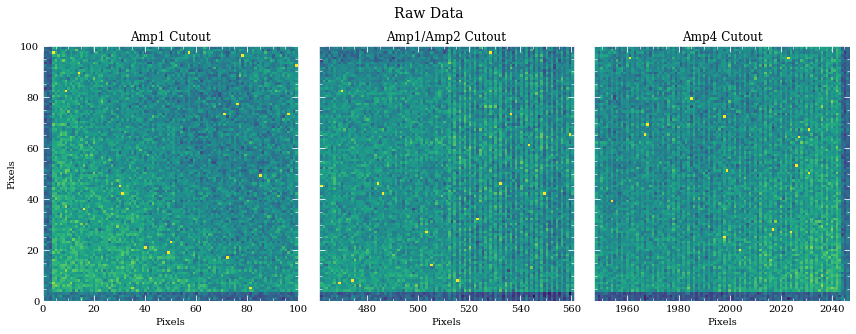

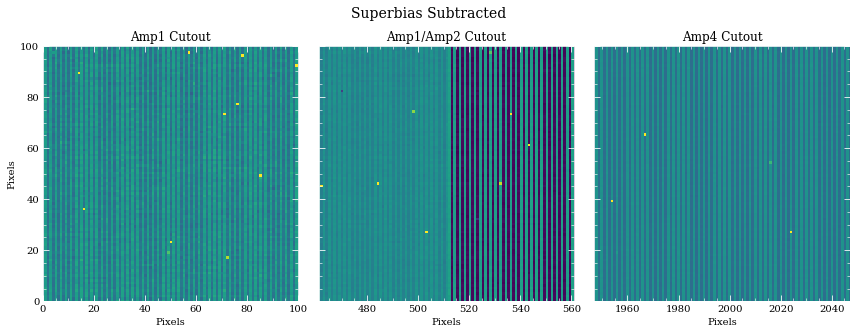

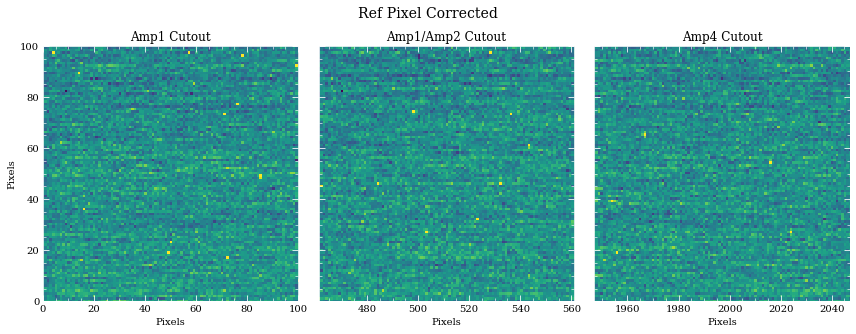

In [8]:
plot_subsections(im_raw, title='Raw Data')
plot_subsections(im_bsub, title='Superbias Subtracted')
plot_subsections(im_reffix, title='Ref Pixel Corrected')

# 1/f Noise Extraction

There are also some functions for extracting and correcting 1/f noise. In the above section, we intentionally excluded 1/f noise corrections so as to not perform multiple smoothings of the column reference pixel data.



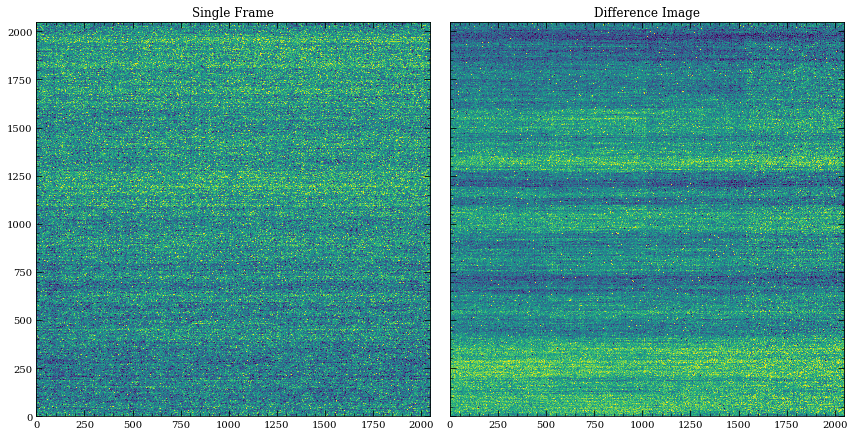

In [9]:
# Plot an image to show the horizontal band of the 
im = data[-1] - data[0]
mn = np.median(im)
std = robust.medabsdev(im)
vmin = mn-3*std
vmax = mn+3*std

fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

titles = ['Single Frame', 'Difference Image']
for i, im in enumerate([data[0], data[-1]-data[0]]):
    mn = np.median(im)
    std = robust.medabsdev(im)
    vmin = mn-3*std
    vmax = mn+3*std

    axes[i].imshow(im, vmin=vmin, vmax=vmax)
    axes[i].set_title(titles[i])

fig.tight_layout()

In the above image, the single frame has a large kTC noise component, which is completely removed during the `frame[-1] - frame[0]` subtraction. In the next step, we attempt to extract the 1/f noise component from the differenced image.

In [10]:
# First, perform 1/f correction using column reference pixels
# Set standard keywords for amplifier offset corrections
kwargs_ref = {
    'nchans': nchans, 'in_place': False, 'altcol': True, 'mean_func': robust.mean,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False,
}

im_diff = data[-1] - data[0]
im_diff_corr = reffix_hxrg(im_diff, **kwargs_ref)

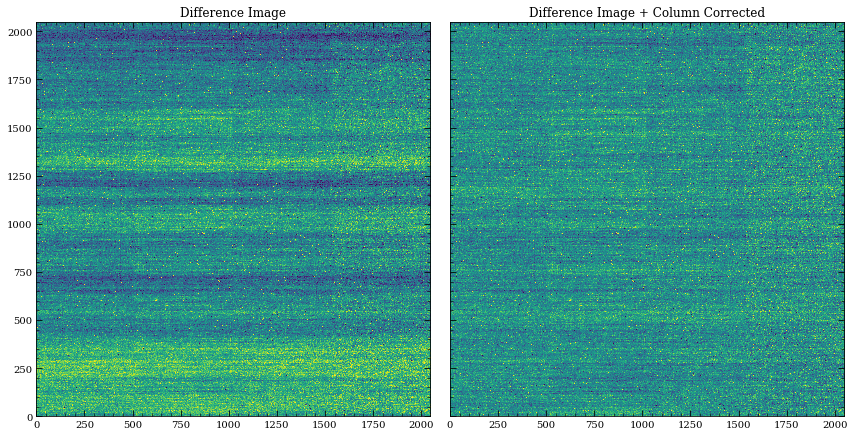

In [11]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

mn = np.median(im_diff)
std = robust.medabsdev(im_diff)
vmin = mn-3*std
vmax = mn+3*std

axes[0].imshow(im_diff, vmin=vmin, vmax=vmax)
axes[1].imshow(im_diff_corr, vmin=vmin, vmax=vmax)

axes[0].set_title('Difference Image')
axes[1].set_title('Difference Image + Column Corrected')

fig.tight_layout()

While the above does a fairly adequate job of removing the major 1/f noise components, there are still some residual horizontal striping in each channel that could hamper high-precision photometry and spectroscopy required for time series observations. There are a couple built-in tools to further estimate these horizontal striping residuals.

For instance, the `channel_averaging` function takes in a single image and estimates the common 1/f noise by averaging the together the four amplifiers. In the event that there is a source in one of the channels, you can get it's 1/f noise by averaging only the off-channels.

Another option is the `channel_smooth_savgol` fucntion, which applies a smoothing filter to each channel individually. A user can pass a mask image to exclude bad pixels and source flux. The function will then produce a linear interpolation over the masked data.

### Channel Averaging

In [12]:
from ref_pixels.ref_pixels import channel_averaging

In [13]:
# Find bad pixels and set to NaN's
mask_good = robust.mean(im_diff_corr, return_mask=True)
mask_bad = ~mask_good
im_temp = im_diff_corr.copy()
im_temp[mask_bad] = np.nan

# Apply channel average to column-corrected data
chmed = channel_averaging(im_temp, off_chans=True, mn_func=np.nanmedian)
im_diff_corr2 = im_diff_corr - chmed

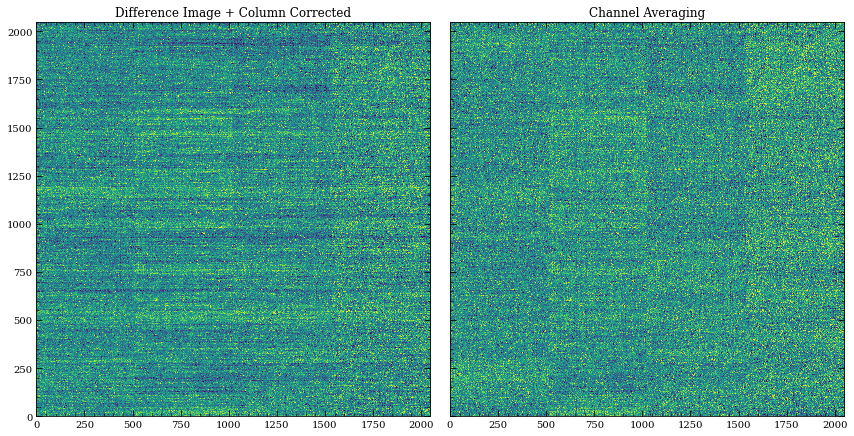

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

mn = np.median(im_diff_corr)
std = robust.medabsdev(im_diff_corr)
vmin = mn-3*std
vmax = mn+3*std

axes[0].imshow(im_diff_corr, vmin=vmin, vmax=vmax)
axes[1].imshow(im_diff_corr2, vmin=vmin, vmax=vmax)

axes[0].set_title('Difference Image + Column Corrected')
axes[1].set_title('Channel Averaging')

fig.tight_layout()

**Note:** In this case, there are some modest gains, but the bulk of the common 1/f noise had already been removed in during the column reference pixel correction. This method could also suffer from extended sources or PSFs in the off-amplifiers.

### Channel Smoothing

In [15]:
from ref_pixels.ref_pixels import channel_smooth_savgol

In [16]:
# Break images into individual channels images of shape (nchan, ny, chsize)
im_chans = im_diff_corr.reshape([ny,nchans,-1]).transpose([1,0,2])
# print(im_chans.shape)

# Create a mask of outliers to ignore using the smoothing function
mask_good = robust.mean(im_chans, return_mask=True)
ch_smth = channel_smooth_savgol(im_chans, mask=~mask_good)

# Reshape back into a full image
ch_smth = ch_smth.transpose([1,0,2]).reshape([ny,nx])

im_diff_corr3 = im_diff_corr - ch_smth

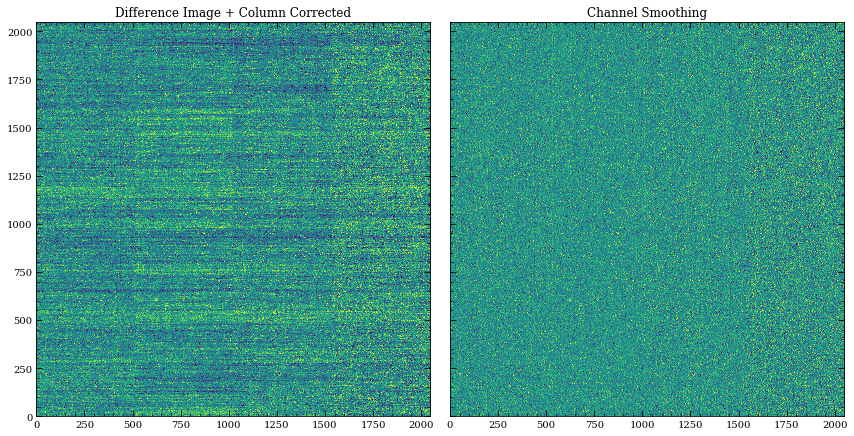

In [17]:
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

mn = np.median(im_diff_corr)
std = robust.medabsdev(im_diff_corr)
vmin = mn-3*std
vmax = mn+3*std

axes[0].imshow(im_diff_corr, vmin=vmin, vmax=vmax)
axes[1].imshow(im_diff_corr3, vmin=vmin, vmax=vmax)

axes[0].set_title('Difference Image + Column Corrected')
axes[1].set_title('Channel Smoothing')

fig.tight_layout()

**Note:** In this scenario, the smoothing function does a pretty decent job estimating the 1/f contributions and subtracting them in the final image. However, care must be taken not to smooth over and subtract actual astrophysical signal. Separating noise structures from astrophysical sources can be challenging for a single slope image, but should be possible using multiple integrations.